In [1]:
# Clean Data
#    Objectif: Clean data based on previous analysis, then visualize the results
#    Input: dataset.csv
#    Output: cleanedData.csv
#    Author: SOUAD BOUTANE

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import warnings

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
######################################   LOAD DATA:   ################################

df = pd.read_csv('../data/dataset.csv')

df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print("Dataset size", df.shape)

Dataset size (6362620, 11)


In [12]:
####################################    DATA PREPROCESSING     ################################
##########################################  CLEAN DATA ########################################

#Relying on EDA, we must to:
#1 Keep only with 'TRANSFER's and 'CASH_OUT' transaction
#2 Remove IsFlaggedFraud
#3 Add new features of errorBalanceDest and errorBalanceDest to deal with missing balance
#4 Add new feature of HourOfDay more meaninful than step
#5 deal with umbalanced data
#   5_1 Remove transactions with errorBalanceDest>-1000000 and errorBalanceOrig<2000000 
#   5_2 Remove a big part of transactions with amount more than 20 millions in the objectef to deal with unbalance pb
#   5_3 Keep only CC transactions and remove CM 


#print ('dataset size :%s'& df_clean.shape)

# 1 only two types of transactions occurs in fraud,So we assemble only the corresponding data in X for analysis
df_clean = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]


# fraud occurs only in customers who's name does not start with M
df_clean = df_clean[~df_clean.nameOrig.str.startswith('M') | ~df_clean.nameDest.str.startswith('M')]

# 3 Eliminate columns shown to be irrelevant for analysis in the EDA
# 4 Remove IsFlaggedFraud,it is meaningful because isFraud always set when IsFlaggedFraud is set
df_clean.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)

# remove transaction with amount more than 2 millions
df_clean = df_clean.loc[(df_clean.amount < 20000000)]


print("Dataset size", df_clean.shape)
df_clean.head()

Dataset size (2770409, 8)


,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [17]:
####################################    DATA PREPROCESSING     ################################
##################################### Features Engineering ####################################


#5 Add new column for amount to deal with missing balanaces => Features engineering

#There is some descrepancy in the data. oldBalanceSender - amount should equal newBalanceSender
# and oldBalanceReceiver + amount should equal newBalanceReceiver but doesn't always occur. create features
# and remove previous balance from both sender and receiver


df_feature = pd.DataFrame(df_clean)
df_feature['errorBalanceOrig'] = df_feature.newBalanceOrig + df_feature.amount - df_feature.oldBalanceOrig
df_feature['errorBalanceDest'] = df_feature.oldBalanceDest + df_feature.amount - df_feature.newBalanceDest
df_feature.drop(['oldBalanceOrig', 'oldBalanceDest'], 1, inplace=True)
df_feature = df_feature.rename(columns={'newBalanceOrig':'balanceSender', 'newBalanceDest':'balanceReceiver'})

#remove transaction with errorBalanceDest>-1000000 and errorBalanceOrig<2000000
df_feature=df_feature.loc[(df_feature.errorBalanceDest>=-10000000) & (df_feature.errorBalanceOrig<=20000000)] 

# adding feature HourOfDay to df_feature 
df_feature["HourOfDay"] = np.nan 
df_feature.HourOfDay = df_feature.step % 24


print("Dataset size", df_feature.shape)
df_feature.head()

#df_feature.dtypes

#change order of columns
df_feature = df_feature[['step','HourOfDay', 'type','amount', 'balanceSender', 'balanceReceiver', 'errorBalanceDest','errorBalanceOrig','isFraud']]


print("Dataset size", df_feature.shape)
df_feature.head()

Dataset size (2768088, 9)
Dataset size (2768088, 9)


,step,HourOfDay,type,amount,balanceSender,balanceReceiver,errorBalanceDest,errorBalanceOrig,isFraud
2,1,1,TRANSFER,181.00,0.0,0.00,181.0,0.00,1
3,1,1,CASH_OUT,181.00,0.0,0.00,21363.0,0.00,1
15,1,1,CASH_OUT,229133.94,0.0,51513.44,182703.5,213808.94,0
19,1,1,TRANSFER,215310.30,0.0,0.00,237735.3,214605.30,0
24,1,1,TRANSFER,311685.89,0.0,2719172.89,-2401220.0,300850.89,0


In [26]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2768088 entries, 2 to 6362619
Data columns (total 9 columns):
step                int64
HourOfDay           int64
type                object
amount              float64
balanceSender       float64
balanceReceiver     float64
errorBalanceDest    float64
errorBalanceOrig    float64
isFraud             int64
dtypes: float64(5), int64(3), object(1)
memory usage: 211.2+ MB


In [27]:
#Save cleaned data
df_feature.to_csv('../data/cleanedData.csv', index=False)

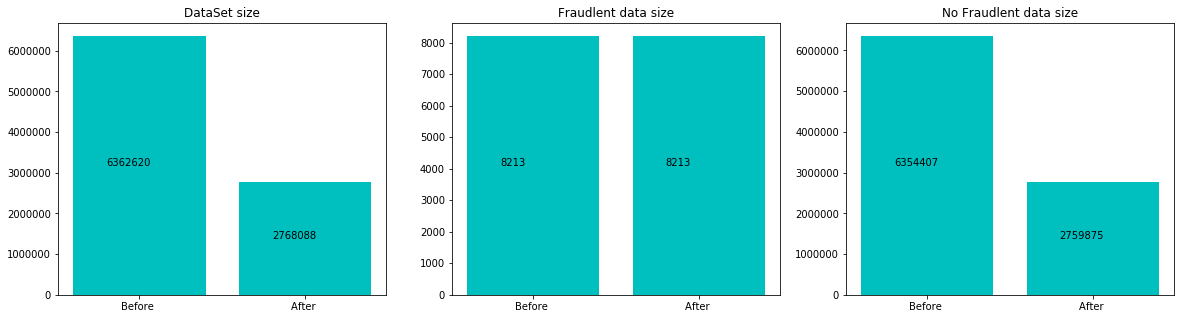

In [18]:
####################################    DATA Visualization     ################################
    ######################################## Size ########################################

f, ax = plt.subplots(1,3, sharex=True,figsize=(20,5))

def plotSize(ax,before,after,t):
    b=ax.bar(['Before ', 'After '], [before,after],color='c')
    ax.set_title(t)
    ax.text(b[0].get_x()+0.2,b[0].get_height()/2,'%d' % int(before))
    ax.text(b[1].get_x()+0.2,b[1].get_height()/2,'%d' % int(after))

#totale size of dataset
before=len(df)
after=len(df_feature)
plotSize(ax[0],before,after,'DataSet size')

#totale size of Fraud records
before=len(df.loc[(df.isFraud == 1)])
after=len(df_feature.loc[(df_feature.isFraud == 1)])
plotSize(ax[1],before,after,'Fraudlent data size')

#totale size of not Fraud records
before=len(df.loc[(df.isFraud == 0)])
after=len(df_feature.loc[(df_feature.isFraud == 0)])
plotSize(ax[2],before,after,"No Fraudlent data size")

plt.show()

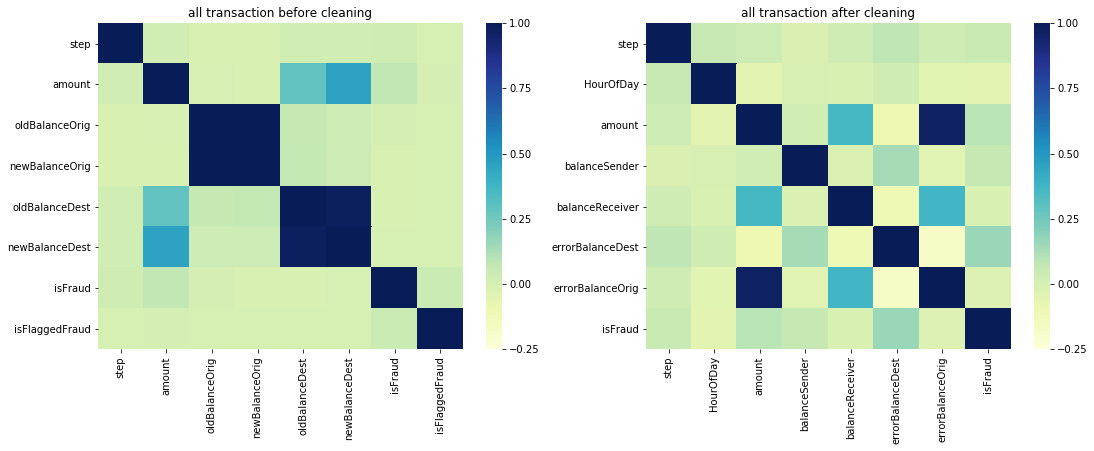

In [19]:
####################################    DATA Visualization     ################################
    ######################################## Correlation all transaction  ########################################

f, ax = plt.subplots(1,2)

#Feature correlation before cleaning
g1=sns.heatmap(df.corr(), vmin=-.25,cmap="YlGnBu",ax=ax[0])
g1.set_title('all transaction before cleaning')

#Feature correlation afetr cleaning
g1=sns.heatmap(df_feature.corr(), vmin=-.25,cmap="YlGnBu",ax=ax[1])
g1.set_title('all transaction after cleaning')

f.set_figheight(6)
f.set_figwidth(18)
plt.show()

In [21]:
X = df_feature.copy()
Y = df_feature['isFraud']
del X['isFraud']


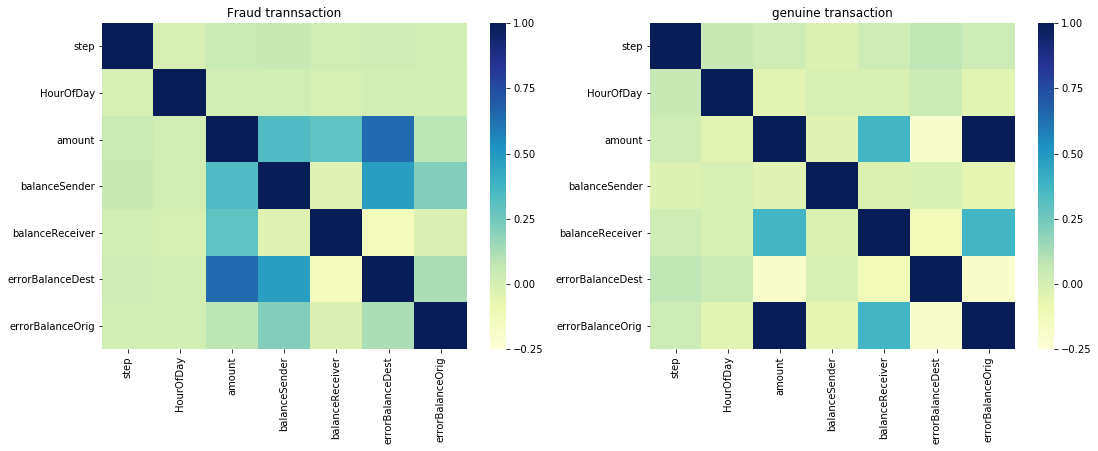

In [22]:
####################################    DATA Visualization     ################################
    ######################################## Correlation all transaction  ########################################

f, ax = plt.subplots(1,2, sharex=True)
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

#Feature correlation before all transaction
g1=sns.heatmap(Xfraud.corr(), vmin=-.25,cmap="YlGnBu",ax=ax[0])
g1.set_title('Fraud trannsaction')

#Feature correlation before all transaction
g1=sns.heatmap(XnonFraud.corr(), vmin=-.25,cmap="YlGnBu",ax=ax[1])
g1.set_title('genuine transaction')

f.set_figheight(6)
f.set_figwidth(18)
plt.show()

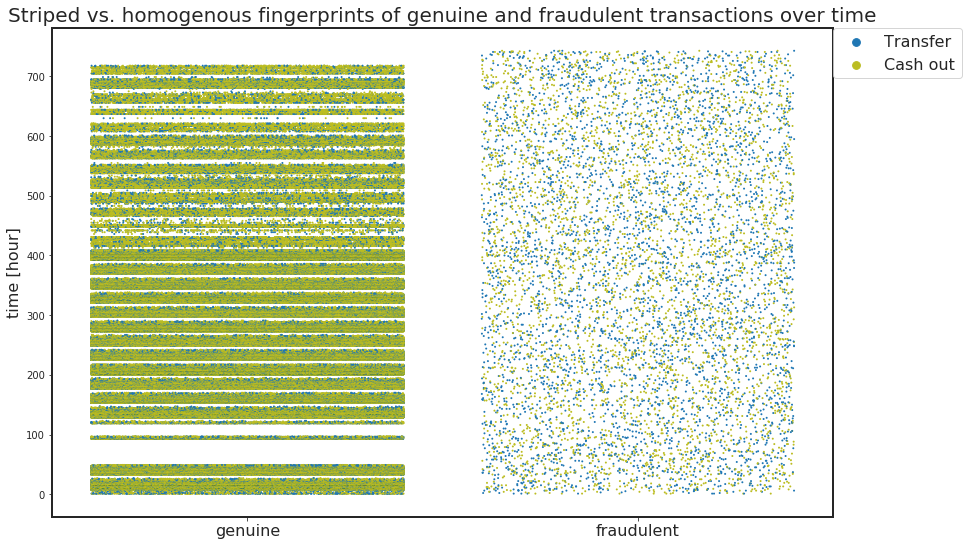

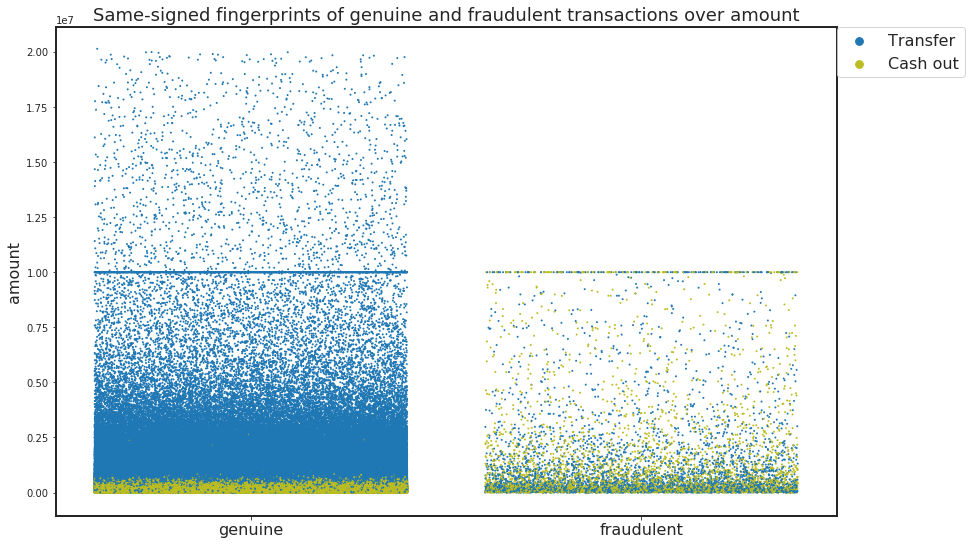

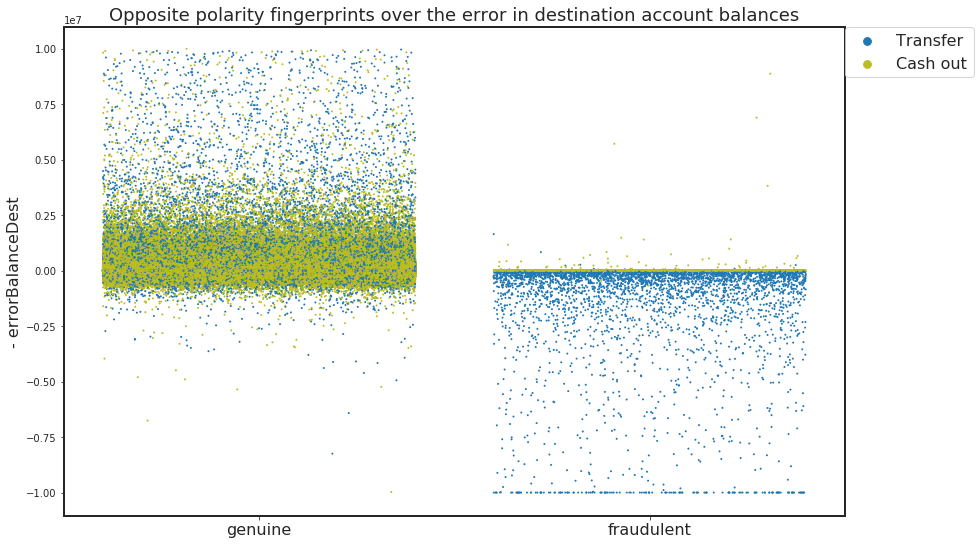

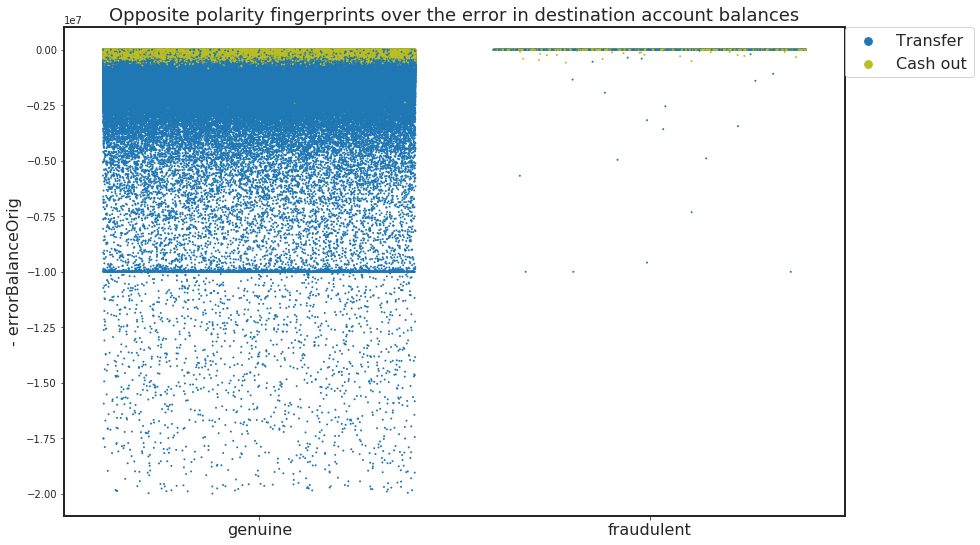

In [23]:
####################################    DATA Visualization     ################################
    ######################################## Information ##################################

#Is our data contains enough information so that a ML algorithm can make strong predictions

limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 5, 7))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

#Dispersion over time
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

#Dispersion over amount
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

#Dispersion over error in balance in destination accounts
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

ax = plotStrip(Y[:limit], - X.errorBalanceOrig[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('- errorBalanceOrig', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);
